In [1]:
import numpy as np
import gymnasium as gym
import panda_gym
import torch
import matplotlib.pyplot as plt
import os
import json
from utils import create_directory, print_env_info, save_training_data
from sac import SAC
from td3 import TD3
from random_search import run_random_search, generate_sac_params, generate_td3_params
from random_search import train_sac_with_params, train_td3_with_params, evaluate_policy
from IPython.display import clear_output, display
import warnings

warnings.filterwarnings('ignore')

# Set up directory structure
create_directory("./results")
create_directory("./results/random_search")
create_directory("./results/random_search/sac")
create_directory("./results/random_search/td3")
create_directory("./results/random_search_her")
create_directory("./results/random_search_her/sac")
create_directory("./results/random_search_her/td3")


Using device: cpu


In [2]:

# Define environment
ENV_NAME = "PandaReach-v3"

# Print environment information
env = gym.make(ENV_NAME)
print_env_info(env)
env.close()

def run_training(algorithm='both', use_her=False, her_strategy="future", k=4, n_trials=5, max_timesteps=30000):
    
    """
    Run random search and training for specified algorithms
    
    Args:
        algorithm: Algorithm to run ('sac', 'td3', 'both', 'sac_her', 'td3_her', 'both_her')
        use_her: Whether to use Hindsight Experience Replay
        n_trials: Number of trials for random search
        max_timesteps: Maximum timesteps per trial
        
    Returns:
        results: Dictionary with training results
    """
    # Determine which algorithms to run
    algorithms = []
    if algorithm == 'both':
        algorithms = ['sac', 'td3']
    elif algorithm == 'sac':
        algorithms = ['sac']
    elif algorithm == 'td3':
        algorithms = ['td3']
    elif algorithm == 'sac_her':
        algorithms = ['sac']
        use_her = True
    elif algorithm == 'td3_her':
        algorithms = ['td3']
        use_her = True
    elif algorithm == 'both_her':
        algorithms = ['sac', 'td3']
        use_her = True
    else:
        print(f"Invalid algorithm: {algorithm}")
        return None
    
    # Set up save directory based on whether HER is used
    save_dir = "./results/random_search_her" if use_her else "./results/random_search"
    
    # Run random search
    print("====================")
    print(f"Running random search for {', '.join(algorithms)}" + (" with HER" if use_her else ""))
    print("====================")
    
    results = run_random_search(
        n_trials=n_trials,
        max_timesteps=max_timesteps,
        save_dir=save_dir,
        use_her=use_her,
        her_strategy=her_strategy,
        her_k=k,
        algorithms=algorithms
    )
    
    # Load best parameters
    best_params_path = f"{save_dir}/best_params{'_her' if use_her else ''}.json"
    
    if os.path.exists(best_params_path):
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)
            
        # Print best parameters
        for alg in algorithms:
            if alg in best_params:
                print(f"\n==== Best {alg.upper()}" + (" + HER" if use_her else "") + f" Parameters ====")
                print(f"Success Rate: {best_params[alg]['success_rate']}")
                for param, value in best_params[alg]['params'].items():
                    print(f"{param}: {value}")
    
    return results

def compare_algorithms(algorithms=['sac', 'td3', 'sac_her', 'td3_her'], 
                      her_strategy="future", k=4, n_trials=3, max_timesteps=30000):
    """
    Compare multiple algorithms by running them and plotting results
    
    Args:
        algorithms: List of algorithms to compare
        n_trials: Number of trials for random search
        max_timesteps: Maximum timesteps per trial
        
    Returns:
        comparison_results: Dictionary with best results for each algorithm
    """
    comparison_results = {}
    
    # Run each algorithm
    for alg in algorithms:
        print(f"\n==== Running {alg.upper()} ====")
        use_her = 'her' in alg
        base_alg = alg.replace('_her', '')
        
        # Run training
        results = run_training(
        algorithm=alg,
        use_her=use_her,
        her_strategy=her_strategy,
        k=k,
        n_trials=n_trials,
        max_timesteps=max_timesteps
        )
        
        # Store results
        if results:
            if base_alg == 'sac' and results.get('sac_results'):
                comparison_results[alg] = max(results['sac_results'], 
                                             key=lambda x: x['final_success_rate'])
            elif base_alg == 'td3' and results.get('td3_results'):
                comparison_results[alg] = max(results['td3_results'],
                                             key=lambda x: x['final_success_rate'])
            elif base_alg == 'both':
                if results.get('sac_results'):
                    comparison_results['sac' + ('_her' if use_her else '')] = max(
                        results['sac_results'], key=lambda x: x['final_success_rate'])
                if results.get('td3_results'):
                    comparison_results['td3' + ('_her' if use_her else '')] = max(
                        results['td3_results'], key=lambda x: x['final_success_rate'])
    
    # Plot comparison if we have results
    if comparison_results:
        plot_algorithm_comparison(comparison_results)
    
    return comparison_results
# Replace your current plot_algorithm_comparison function with this one
def plot_algorithm_comparison(comparison_results):
    """
    Plot comprehensive comparison of algorithm performance
    
    Args:
        comparison_results: Dictionary with best results for each algorithm
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Line styles and colors for each algorithm
    styles = {
        'sac': {'color': 'blue', 'linestyle': '-', 'label': 'SAC'},
        'td3': {'color': 'orange', 'linestyle': '-', 'label': 'TD3'},
        'sac_her': {'color': 'green', 'linestyle': '-', 'label': 'SAC+HER'},
        'td3_her': {'color': 'red', 'linestyle': '-', 'label': 'TD3+HER'}
    }
    
    # Plot 1: Success rates over evaluations
    ax1 = axes[0, 0]
    for alg, result in comparison_results.items():
        if 'success_rates' in result and len(result['success_rates']) > 0:
            ax1.plot(range(len(result['success_rates'])), result['success_rates'], 
                     **styles[alg.lower()])
    ax1.set_xlabel('Evaluation Step')
    ax1.set_ylabel('Success Rate')
    ax1.set_title('Success Rate vs Evaluation Step')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Rewards over episodes
    ax2 = axes[0, 1]
    for alg, result in comparison_results.items():
        if 'rewards' in result and len(result['rewards']) > 0:
            # Smooth rewards if possible
            if len(result['rewards']) > 10:
                window_size = min(10, len(result['rewards']) // 5)
                weights = np.ones(window_size) / window_size
                smoothed = np.convolve(result['rewards'], weights, mode='valid')
                ax2.plot(range(len(smoothed)), smoothed, **styles[alg.lower()])
            else:
                ax2.plot(range(len(result['rewards'])), result['rewards'], **styles[alg.lower()])
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Reward')
    ax2.set_title('Episode Reward vs Episode')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Episode lengths over episodes
    ax3 = axes[0, 2]
    for alg, result in comparison_results.items():
        if 'episode_lengths' in result and len(result['episode_lengths']) > 0:
            # Smooth episode lengths if possible
            if len(result['episode_lengths']) > 10:
                window_size = min(10, len(result['episode_lengths']) // 5)
                weights = np.ones(window_size) / window_size
                smoothed = np.convolve(result['episode_lengths'], weights, mode='valid')
                ax3.plot(range(len(smoothed)), smoothed, **styles[alg.lower()])
            else:
                ax3.plot(range(len(result['episode_lengths'])), result['episode_lengths'], 
                         **styles[alg.lower()])
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Episode Length')
    ax3.set_title('Episode Length vs Episode')
    ax3.legend()
    ax3.grid(True)
    
    # Plot 4: Final success rates (bar chart)
    ax4 = axes[1, 0]
    algs = list(comparison_results.keys())
    success_rates = [result['final_success_rate'] for result in comparison_results.values()]
    colors = [styles[alg.lower()]['color'] for alg in algs]
    
    ax4.bar(algs, success_rates, color=colors)
    ax4.set_xlabel('Algorithm')
    ax4.set_ylabel('Final Success Rate')
    ax4.set_title('Final Success Rate Comparison')
    ax4.grid(True)
    
    # Plot 5: Training time / convergence speed
    ax5 = axes[1, 1]
    steps_to_converge = []
    for alg, result in comparison_results.items():
        if 'success_rates' in result and len(result['success_rates']) > 1:
            # Define convergence as reaching 90% of final success rate
            threshold = 0.9 * result['final_success_rate']
            for i, rate in enumerate(result['success_rates']):
                if rate >= threshold:
                    steps_to_converge.append(i)
                    break
            else:
                steps_to_converge.append(len(result['success_rates']))
        else:
            steps_to_converge.append(0)
    
    ax5.bar(algs, steps_to_converge, color=colors)
    ax5.set_xlabel('Algorithm')
    ax5.set_ylabel('Evaluations to Converge')
    ax5.set_title('Convergence Speed')
    ax5.grid(True)
    
    # Plot 6: Average episode length
    ax6 = axes[1, 2]
    avg_lengths = []
    for result in comparison_results.values():
        if 'episode_lengths' in result and len(result['episode_lengths']) > 0:
            # Average of last 10% of episodes
            cutoff = max(1, int(len(result['episode_lengths']) * 0.9))
            avg_lengths.append(np.mean(result['episode_lengths'][cutoff:]))
        else:
            avg_lengths.append(0)
    
    ax6.bar(algs, avg_lengths, color=colors)
    ax6.set_xlabel('Algorithm')
    ax6.set_ylabel('Avg Episode Length')
    ax6.set_title('Final Average Episode Length')
    ax6.grid(True)
    
    plt.tight_layout()
    plt.savefig('./results/comprehensive_comparison.png')
    plt.show()

---------------------------------------
Environment: PandaReach-v3
Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))
Action Space: Box(-1.0, 1.0, (3,), float32)
Action Space High: [1. 1. 1.]
Action Space Low: [-1. -1. -1.]
---------------------------------------



==== Running SAC_HER ====
Running random search for sac with HER
---------------------------------------
Environment: PandaReach-v3
Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))
Action Space: Box(-1.0, 1.0, (3,), float32)
Action Space High: [1. 1. 1.]
Action Space Low: [-1. -1. -1.]
---------------------------------------

==== Running Random Search for SAC with HER ====

SAC Trial 1/2
Parameters: {'hidden_dim': 256, 'lr': 0.0007, 'gamma': 0.924964165892988, 'tau': 0.02, 'alpha': 0.12378985986272589, 'automatic_entropy_tuning': True, 'batch_size': 128, 'buffer_size': 200000, 'learning_starts': 1000}
Episode 1: Total reward = -50.000, Length = 50
Episode 2: Total reward = -50.000, Length = 50
Episode 3: Total reward = -5.000, Length = 6
Episode 4: Total reward = -50.000, Length = 50
Episode 5: Total reward = -50.000, Length = 50
Episode 6: Total reward = -28.000,

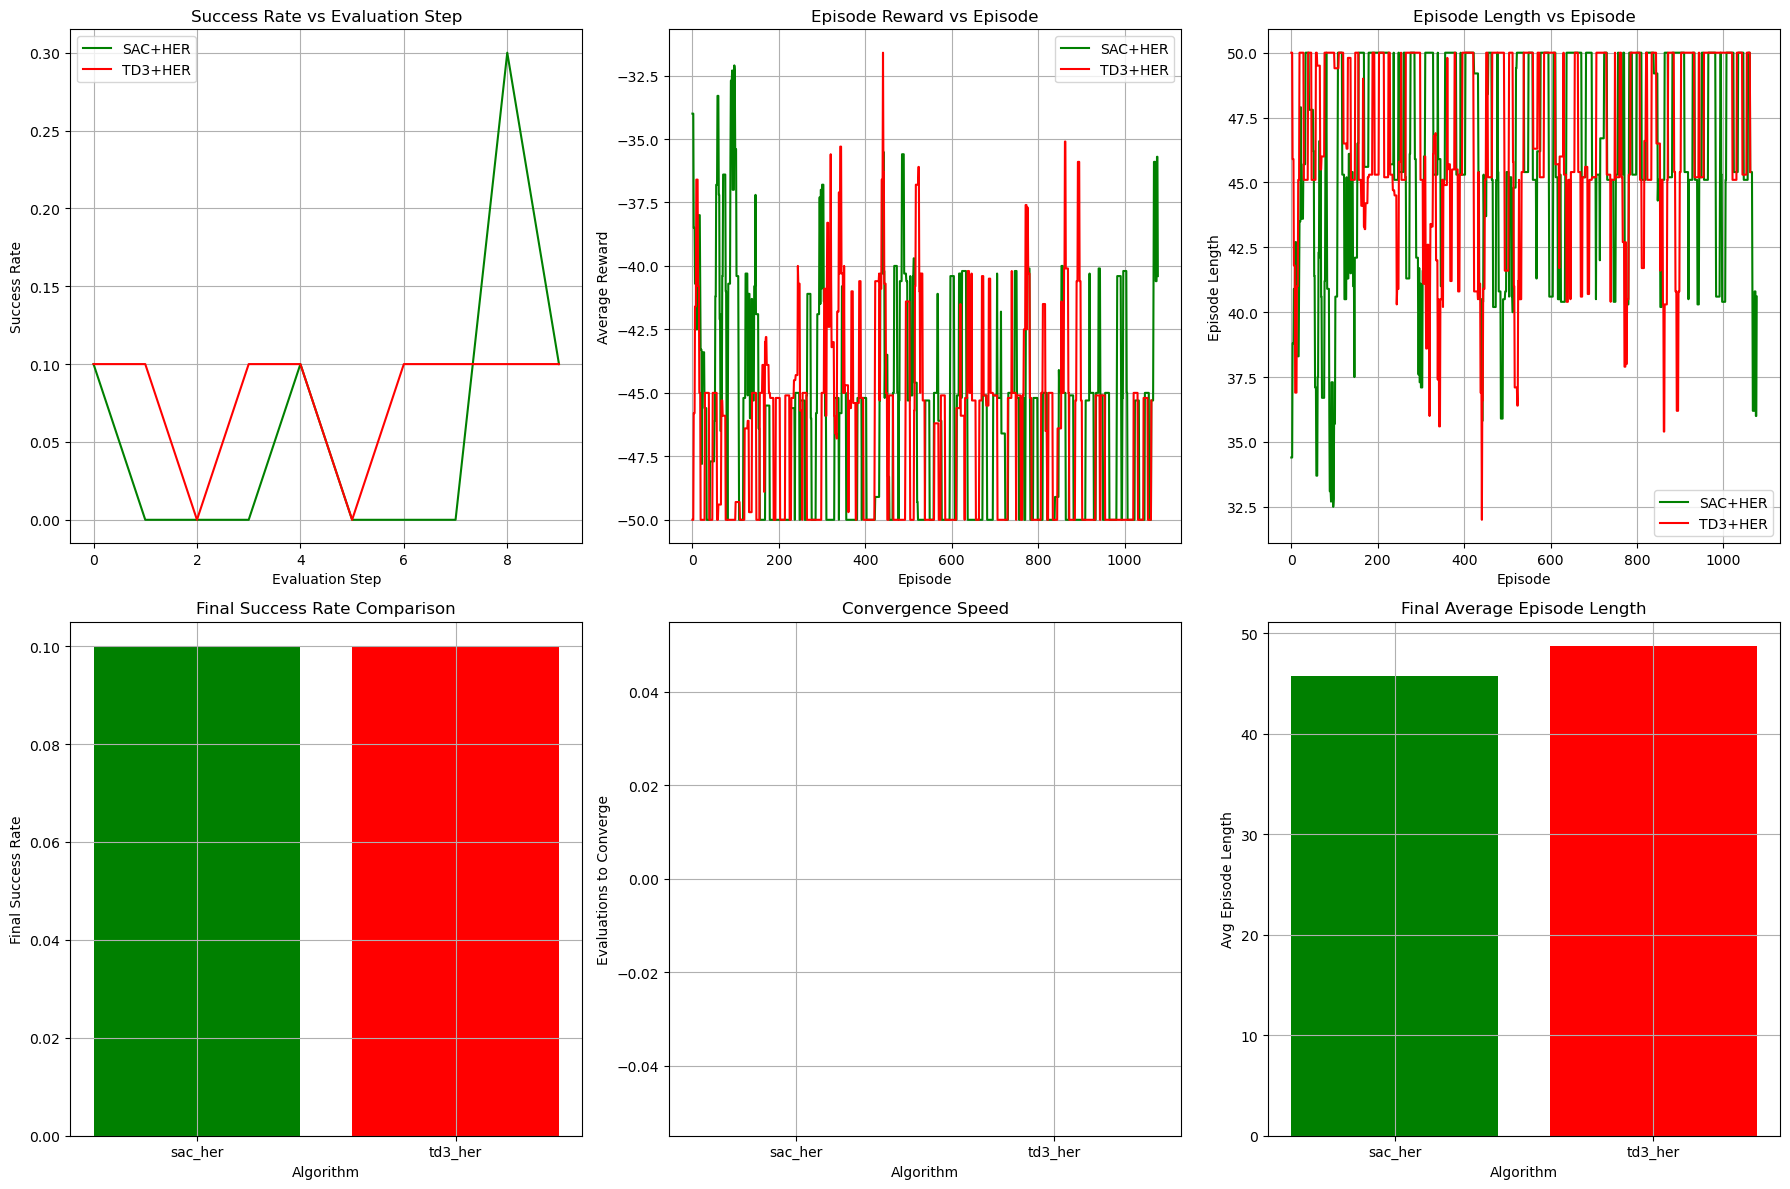

In [3]:
# Execute this in Jupyter notebook
if __name__ == "__main__":
    # Run a single algorithm
    #results = run_training(algorithm='sac', n_trials=3, max_timesteps=30000)
    
    # Run with HER
    #results_her = run_training(algorithm='sac_her', n_trials=3, max_timesteps=30000)  
    
    # Compare algorithms with the "future" strategy (default)
    comparison = compare_algorithms(
        algorithms=['sac_her', 'td3_her'],
        her_strategy="future",  # Using future strategy
        k=4,                   # Sample 4 goals per transition
        n_trials=2,
        max_timesteps=50000
    )
